# Run ABE8e DESeq2 Model

### Prepare Data Input

You will only need the encoding output from the previous step. You can also download the pre-computed encoding from [Zenodo](https://doi.org/10.5281/zenodo.13737880) at path: 
- CRISPR-CLEAR-data/data/encoding_output/20240807_v0_1_84_encoding_dataframes_denoised_removed_ABE8e_encodings_rep0.tsv
- CRISPR-CLEAR-data/data/encoding_output/20240807_v0_1_84_encoding_dataframes_denoised_removed_ABE8e_encodings_rep1.tsv
- CRISPR-CLEAR-data/data/encoding_output/20240807_v0_1_84_encoding_dataframes_denoised_removed_ABE8e_encodings_rep2.tsv

### Import Packages

In [1]:
from crispr_millipede import encoding as cme
from crispr_millipede import modelling as cmm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data

### Prepare Millipede specification parameters

In [2]:
design_matrix_spec = cmm.MillipedeDesignMatrixProcessingSpecification(
    wt_normalization=False,
    total_normalization=True,
    sigma_scale_normalized=True,
    decay_sigma_scale=True,
    K_enriched=5,
    K_baseline=5,
    a_parameter=0.0005,
    set_offset_as_presort = True,
    offset_normalized = False,
    offset_psuedocount = 1
)

millipede_model_specification_set = {
    "joint_replicate_per_experiment_models" : cmm.MillipedeModelSpecification(
        model_types=[cmm.MillipedeModelType.NORMAL_SIGMA_SCALED, cmm.MillipedeModelType.NORMAL],
        replicate_merge_strategy=cmm.MillipedeReplicateMergeStrategy.COVARIATE,
        experiment_merge_strategy=cmm.MillipedeExperimentMergeStrategy.SEPARATE,
        S = 5,
        tau = 0.01,
        tau_intercept = 0.0001,
        cutoff_specification=cmm.MillipedeCutoffSpecification(
            per_replicate_each_condition_num_cutoff = 0, 
            per_replicate_all_condition_num_cutoff = 1, 
            all_replicate_num_cutoff = 0, 
            all_experiment_num_cutoff = 0,
            baseline_pop_all_condition_each_replicate_num_cutoff = 3,
            baseline_pop_all_condition_acceptable_rep_count = 2,
            enriched_pop_all_condition_each_replicate_num_cutoff = 3,
            enriched_pop_all_condition_acceptable_rep_count = 2,
            presort_pop_all_condition_each_replicate_num_cutoff = 3,
            presort_pop_all_condition_acceptable_rep_count = 2,
            
        ),
        design_matrix_processing_specification=design_matrix_spec
    )
}

In [3]:
paired_end_experiments_inputdata_denoised = cmm.MillipedeInputDataExperimentalGroup(
    data_directory="./", 
    enriched_pop_fn_experiment_list = ["20240807_v0_1_84_encoding_dataframes_denoised_removed_ABE8e_encodings_rep{}.tsv"],
    enriched_pop_df_reads_colname = "#Reads_CD19minus",
    baseline_pop_fn_experiment_list = ["20240807_v0_1_84_encoding_dataframes_denoised_removed_ABE8e_encodings_rep{}.tsv"],
    baseline_pop_df_reads_colname = "#Reads_CD19plus", 
    presort_pop_fn_experiment_list = ["20240807_v0_1_84_encoding_dataframes_denoised_removed_ABE8e_encodings_rep{}.tsv"],
    presort_pop_df_reads_colname = '#Reads_presort',
    experiment_labels = ["ABE8e"],
    reps = [0,1,2],
    millipede_model_specification_set = millipede_model_specification_set
   )

Performing initial input validation checks...
Passed validation.
Retrieving data for
	Replicate Merge Strategy: MillipedeReplicateMergeStrategy.COVARIATE 
	Experiment Merge Strategy MillipedeExperimentMergeStrategy.SEPARATE
	Cutoff: 
                    per_replicate_each_condition_num_cutoff=0, 
                    per_replicate_presort_condition_num_cutoff=0, 
                    per_replicate_all_condition_num_cutoff=1, 
                    all_replicate_num_cutoff=0, 
                    all_experiment_num_cutoff=0, 
                    baseline_pop_per_condition_acceptable_rep_count=0, 
                    baseline_pop_per_condition_acceptable_rep_count=0, 
                    baseline_pop_per_condition_acceptable_rep_count=0,
                    enriched_pop_per_condition_each_replicate_num_cutoff=0,
                    enriched_pop_per_condition_acceptable_rep_count=0,
                    presort_pop_per_condition_each_replicate_num_cutoff=0,
                    presort_pop_per_

### Prepare DESeq2 count matrix

In [4]:
amplicon = "ACATGCTCTAGTGAAAGCCAGTCTGGGCAGCTGGGTAGCTAATGAGGGGATTAGAGAGATTTTGTTGAATGAAAGGCAGATTGAGTCCTGCTACTCGCCCCCTTCATTCCCCTTCATTCATGCCTCATTCTTCCGCCTCCCAGCCGCCTCAACTGGCCAAAGGGAAGTGGAGGCCCTGCCACCTGTAGGGAGGGTCCCCTGGGGCTTGCCCACAGCAAACAGGAAGTCACAGCCTGGTGAGATGGGCCTGGGAATCAGCCACTGAGAAAGTGGGTCTCTTGGGTCCCTGAATTCTTTTTCTGAGTCCCTGCAGCAGTGAAAAAGACACAGAGGCACATAGAGAGTG"

In [5]:
data = paired_end_experiments_inputdata_denoised.millipede_model_specification_set_with_data['joint_replicate_per_experiment_models'][1].data[0]
alleles = [data[data['intercept_exp0_rep0'] == 1], data[data['intercept_exp0_rep1'] == 1], data[data['intercept_exp0_rep2'] == 1]]

In [6]:
allele_tables = []

for rep in range(3):
    cols = list(alleles[rep].columns.values)
    restricted_cols = [col for col in cols if ">" in col]
    
    label = []
    edits = []
    
    minus = []
    plus = []
    presort = []    

    for index, row in alleles[rep].iterrows():
        row_restricted = row[restricted_cols]
        cols_selected = row_restricted[row_restricted == 1].index.tolist()
        
        allele = amplicon
        for col in cols_selected:
            demarker = col.find(">")
            pos = int(col[:demarker - 1])
            alt = col[demarker+1:]
            allele = allele[:pos] + alt + allele[pos + 1:]
                 
        if len(cols_selected) == 0:
            edits.append("wt")
        else:
            edits.append(",".join(cols_selected))
        
        minus.append(row["#Reads_CD19minus_raw"])
        plus.append(row["#Reads_CD19plus_raw"])
        
    dicto = {"edits": edits,
             "CD19minus_rep" + str(rep + 1): minus,
             "CD19plus_rep" + str(rep + 1): plus}
    
    allele_tables.append(pd.DataFrame(dicto).set_index("edits"))

In [7]:
merged_df = pd.merge(allele_tables[0], allele_tables[1], on='edits', how='outer').fillna(0)
merged_df = pd.merge(merged_df, allele_tables[2], on='edits', how='outer').fillna(0)

In [8]:
count_df = merged_df.T
count_df.index.names = ['sample']

In [9]:
count_df

edits,wt,324A>G,322A>G,"322A>G,324A>G",321A>G,"321A>G,324A>G","321A>G,322A>G","321A>G,322A>G,324A>G",320A>G,"320A>G,322A>G,324A>G",...,"49A>G,52A>G,311A>G,314A>G","40A>G,41A>G,254T>C","36A>G,270T>C,274T>C,276T>C,278T>C,279T>C","36A>G,41A>G","36A>G,40A>G,112T>C,113T>C","35T>C,39T>C,274T>C,276T>C,278T>C,279T>C","35T>C,39T>C,42T>C,254T>C","35T>C,39T>C,42T>C,148T>C,153T>C","28A>G,36A>G,112T>C,113T>C","21T>C,314A>G,318A>G,319A>G,320A>G"
sample,,,,,,,,,,,,,,,,,,,,,
CD19minus_rep1,359314.0,856.0,413.0,208.0,146.0,4.0,3.0,186.0,84.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CD19plus_rep1,345867.0,463.0,401.0,267.0,144.0,3.0,1.0,41.0,51.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CD19minus_rep2,374063.0,677.0,397.0,441.0,165.0,25.0,11.0,145.0,57.0,0.0,...,1.0,3.0,6.0,53.0,1.0,3.0,21.0,3.0,3.0,22.0
CD19plus_rep2,416616.0,707.0,471.0,275.0,162.0,0.0,1.0,21.0,86.0,0.0,...,13.0,0.0,3.0,5.0,25.0,2.0,0.0,1.0,0.0,0.0
CD19minus_rep3,285837.0,505.0,342.0,173.0,107.0,48.0,4.0,117.0,101.0,0.0,...,0.0,4.0,0.0,7.0,0.0,3.0,7.0,1.0,3.0,6.0
CD19plus_rep3,371719.0,552.0,321.0,373.0,190.0,2.0,2.0,91.0,68.0,16.0,...,3.0,0.0,5.0,0.0,26.0,2.0,0.0,4.0,0.0,1.0


### Prepare DESeq2 design matrix

In [10]:
samples = list(count_df.index)
condition = ["CD19-", "CD19+"] * 3
replicate = [1, 1, 2, 2, 3, 3]
metadata_dict = {"sample": samples,
                 "condition": condition,
                 "replicate": replicate}

metadata_df = pd.DataFrame(metadata_dict).set_index("sample")

In [11]:
metadata_df

,condition,replicate
sample,,
CD19minus_rep1,CD19-,1
CD19plus_rep1,CD19+,1
CD19minus_rep2,CD19-,2
CD19plus_rep2,CD19+,2
CD19minus_rep3,CD19-,3
CD19plus_rep3,CD19+,3


### Run DESeq2

In [12]:
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    counts=count_df,
    metadata=metadata_df,
    design_factors="condition",
    refit_cooks=True,
    inference=inference,
    # n_cpus=8, # n_cpus can be specified here or in the inference object
)

In [13]:
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.29 seconds.

Fitting dispersion trend curve...
... done in 0.08 seconds.

Fitting MAP dispersions...
... done in 0.26 seconds.

Fitting LFCs...
... done in 0.22 seconds.

Refitting 0 outliers.



In [14]:
stat_res = DeseqStats(dds, inference=inference)

In [15]:
stat_res.summary(lfc_null=0.1, alt_hypothesis="greaterAbs")

Running Wald tests...
... done in 0.16 seconds.



Log2 fold change & Wald test p-value: condition CD19- vs CD19+
                                              baseMean  log2FoldChange  \
edits                                                                    
wt                                       359460.067648       -0.312028   
324A>G                                      617.832119        0.078058   
322A>G                                      392.350014       -0.205255   
322A>G,324A>G                               286.740946       -0.348378   
321A>G                                      152.222553       -0.415302   
...                                                ...             ...   
35T>C,39T>C,274T>C,276T>C,278T>C,279T>C       1.685542        0.566967   
35T>C,39T>C,42T>C,254T>C                      4.343510        5.483560   
35T>C,39T>C,42T>C,148T>C,153T>C               1.469573       -0.456465   
28A>G,36A>G,112T>C,113T>C                     1.012314        3.376861   
21T>C,314A>G,318A>G,319A>G,320A>G             4.4

In [16]:
stat_res.lfc_shrink(coeff="condition_CD19-_vs_CD19+")

Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: condition CD19- vs CD19+
                                              baseMean  log2FoldChange  \
edits                                                                    
wt                                       359460.067648       -0.429522   
324A>G                                      617.832119        0.055382   
322A>G                                      392.350014       -0.139206   
322A>G,324A>G                               286.740946       -0.159227   
321A>G                                      152.222553       -0.285567   
...                                                ...             ...   
35T>C,39T>C,274T>C,276T>C,278T>C,279T>C       1.685542        0.008121   
35T>C,39T>C,42T>C,254T>C                      4.343510        0.031016   
35T>C,39T>C,42T>C,148T>C,153T>C               1.469573       -0.005607   
28A>G,36A>G,112T>C,113T>C                     1.012314        0.018602   
21T>C,314A>G,318A>G,319A>G,320A>G         

... done in 0.25 seconds.



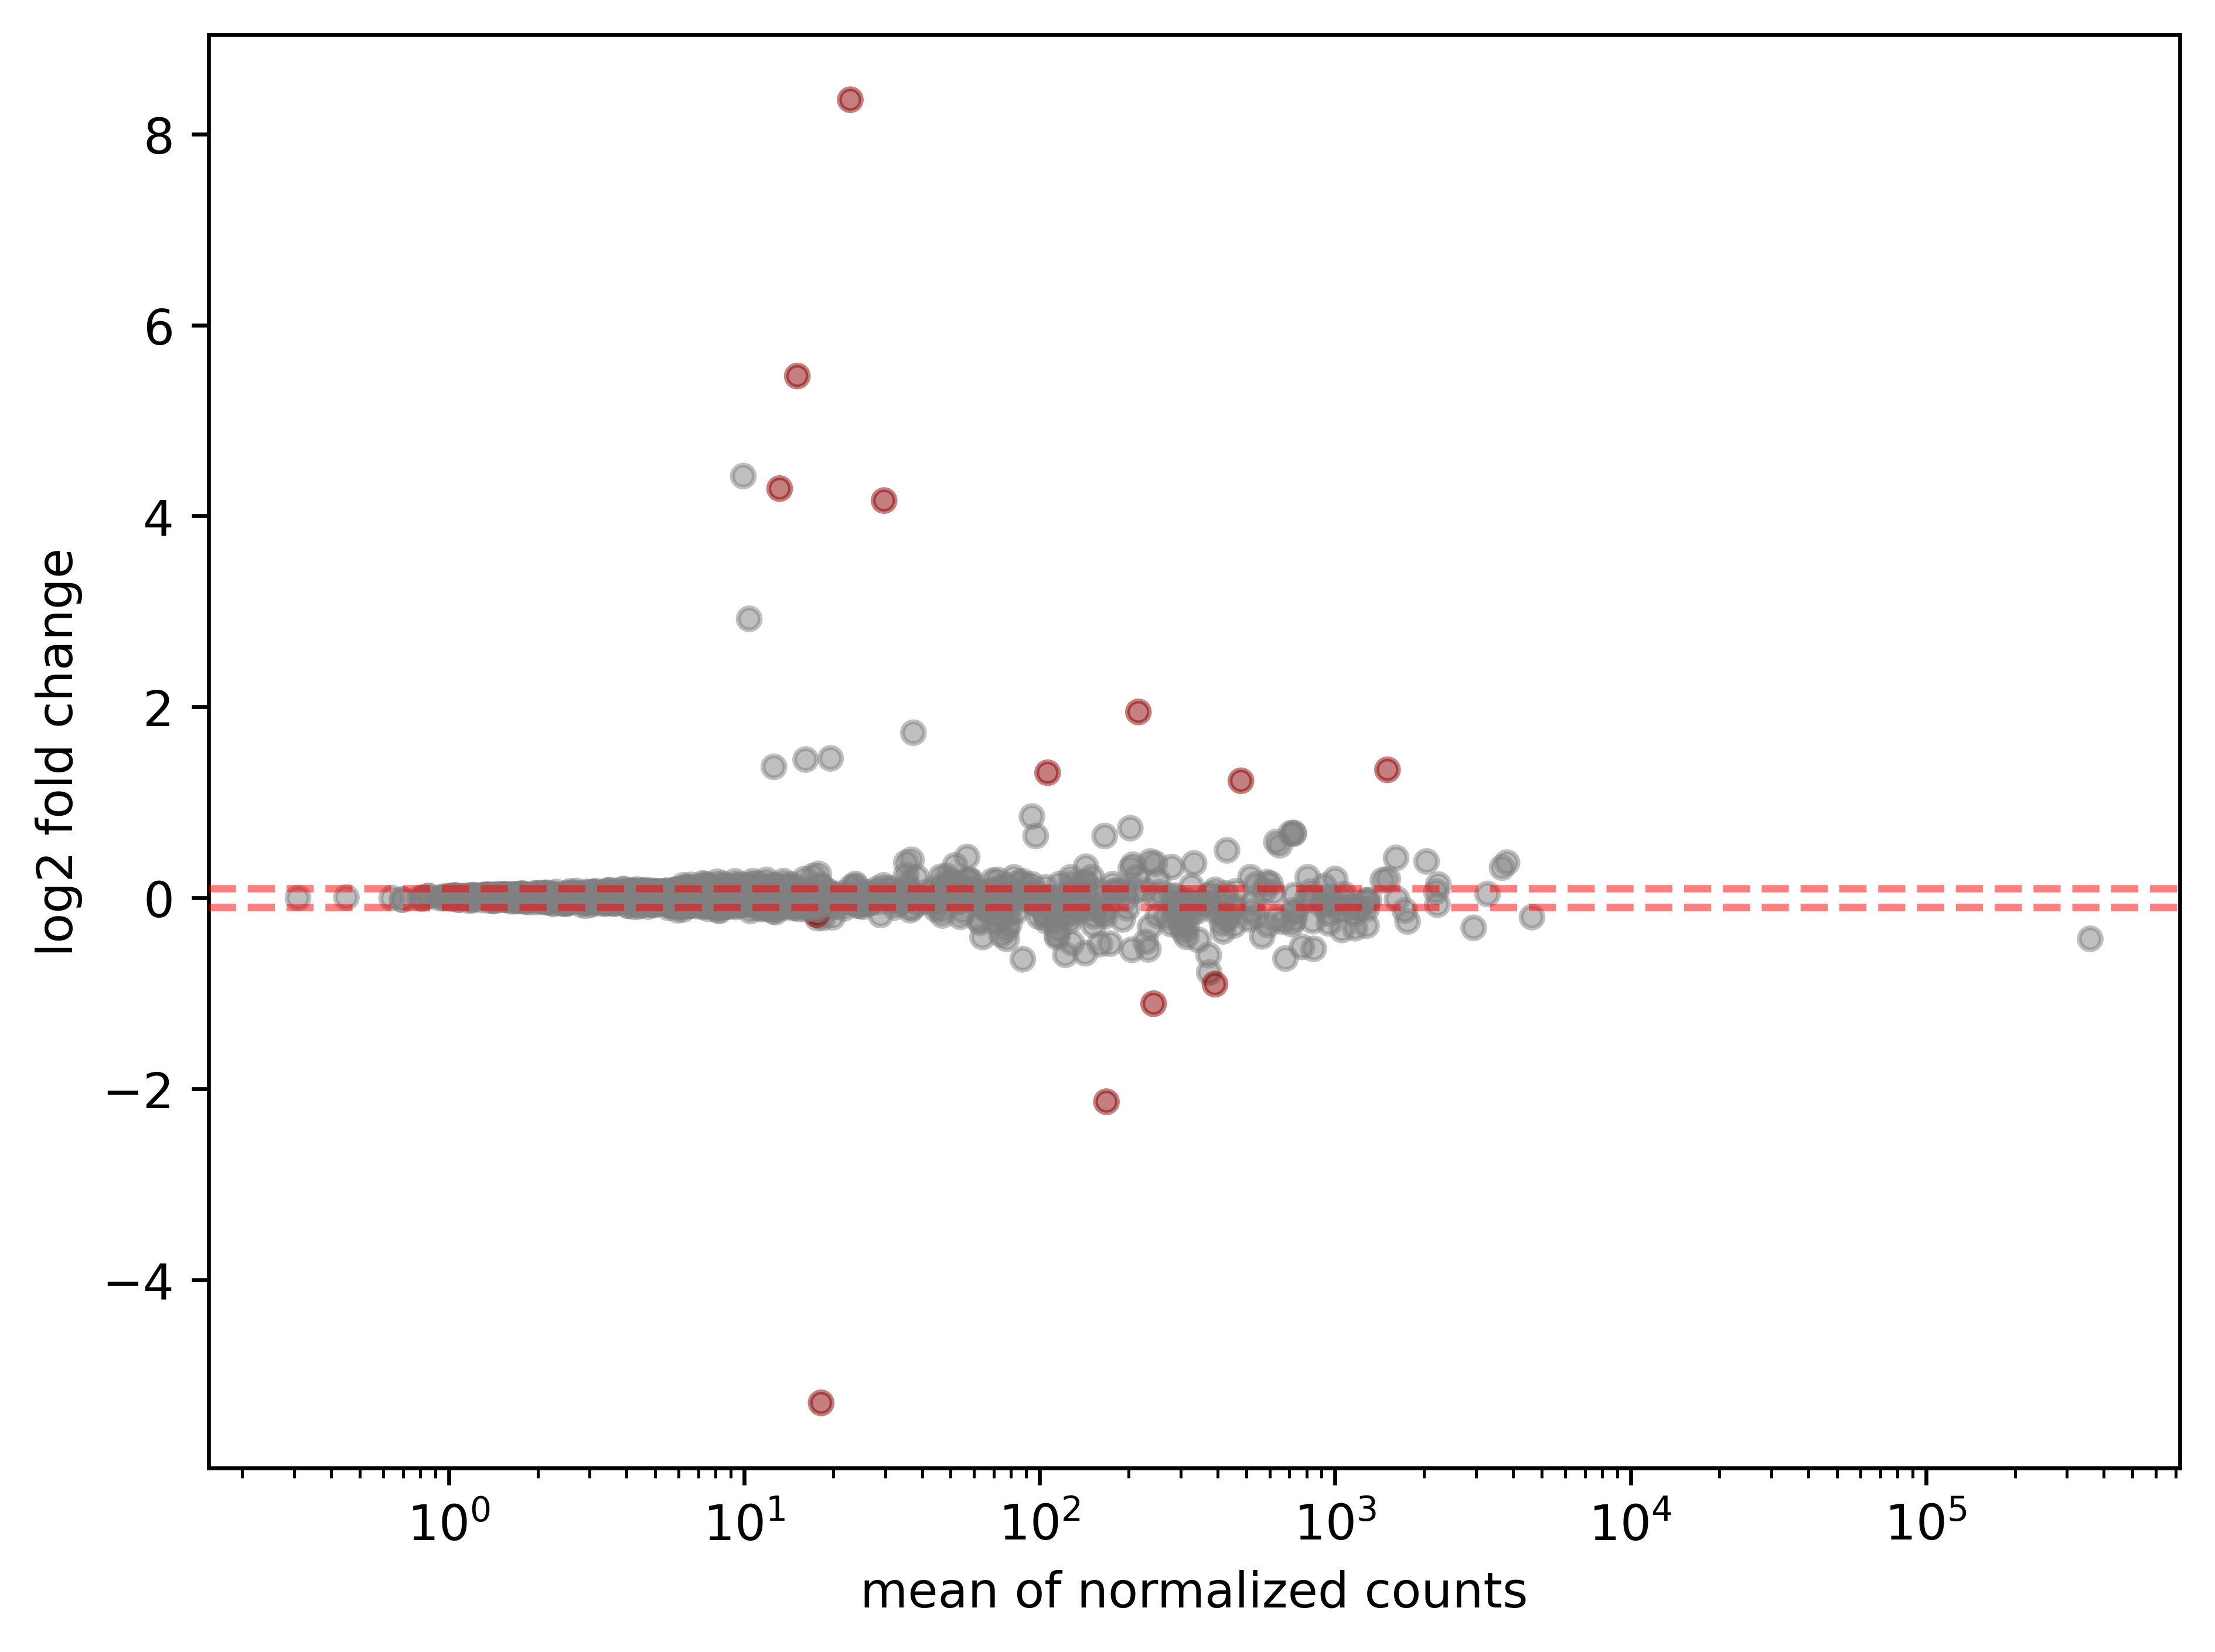

In [17]:
stat_res.plot_MA(s=20)

### Visualize 

In [18]:
results_df = stat_res.results_df
results_df = results_df[['log2FoldChange','padj']].dropna()
negative_log = np.log10(list(results_df["padj"])) * -10
results_df["-10 * log(pvalue)"] = negative_log

In [19]:
results_df

,log2FoldChange,padj,-10 * log(pvalue)
edits,,,
wt,-0.429522,0.130860,8.831945
324A>G,0.055382,1.000000,-0.000000
322A>G,-0.139206,0.899455,0.460203
"322A>G,324A>G",-0.159227,0.789818,1.024728
321A>G,-0.285567,0.543264,2.649889
...,...,...,...
"91T>C,94T>C,223A>G,224A>G,228A>G,230A>G",0.029725,0.455543,3.414710
"72A>G,73A>G,77A>G,79A>G",0.016499,0.976428,0.103596
"36A>G,41A>G",0.040599,0.511436,2.912085


In [20]:
def contains_edit_special(edit, edit2):
    colors = []
    sizes = []
    
    subset_df = results_df.copy()
    
    for index, row in subset_df.iterrows():
        if len(set(edit).intersection(set(index.split(",")))) > 0:
            colors.append("#00AEEF")
            sizes.append(40)
        elif len(set(edit2).intersection(set(index.split(",")))) > 0:
            colors.append("#EC008C")
            sizes.append(40)
        else:
            colors.append("gray")
            sizes.append(40)
            subset_df.drop(index, inplace=True)
    
    # Create the plot
    plt.figure(figsize=(8, 5))
    
    # Scatter plot
    plt.scatter(results_df['log2FoldChange'] * -1, 
                results_df['-10 * log(pvalue)'],
                c=colors, s=sizes, alpha=0.3)
    
    # Set x-axis to log2 scale
    plt.xscale('symlog', base=2)
    
    # Set axis labels and title
    plt.xlabel("Log2 Fold Change [CD19+ vs CD19-]", fontsize=14)
    plt.ylabel("-10 * log10(pvalue)", fontsize=14)
    plt.title("Volcano Plot", fontsize=16)
    
    # Set x-axis limits and ticks
    plt.xlim(-10, 10)
    
    # Set y-axis limits
    plt.ylim(0, 30)
    ax = plt.gca()  # Get current axis
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Save the figure
    plt.savefig("ABE8e_allelic_analysis_w_MillipedeHits.svg")

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()
    
    # Display the subset dataframe
    display(subset_df)

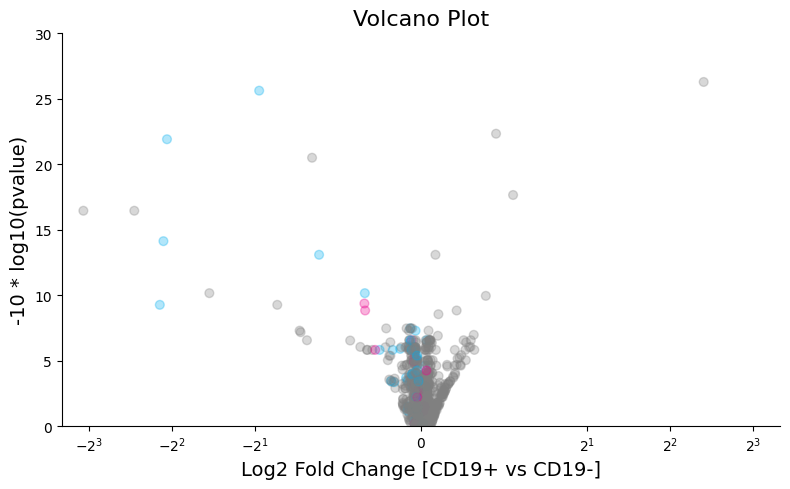

,log2FoldChange,padj,-10 * log(pvalue)
edits,,,
230A>G,0.360930,0.452753,3.441391
"228A>G,230A>G",0.675535,0.096476,10.155798
"228A>G,230A>G,266A>G,267A>G,268A>G",-0.050472,0.345203,4.619254
"228A>G,230A>G,248T>C",0.037772,0.607846,2.162063
"224A>G,230A>G",0.157716,0.449206,3.475543
...,...,...,...
"21T>C,223A>G,224A>G,228A>G,230A>G",0.114227,0.261708,5.821832
"223A>G,224A>G,228A>G,308T>C",0.045563,0.374725,4.262877
"218A>G,220A>G,223A>G,224A>G,228A>G,230A>G",0.046694,0.289300,5.386519


In [21]:
contains_edit_special(["223A>G", "230A>G"], ["151A>G"])